# CS 109A/AC 209A/STAT 121A Data Science: Homework 4
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, October 5th, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW4.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [77]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.cross_validation import KFold
from statsmodels.regression.linear_model import OLS
import sklearn.preprocessing as Preprocessing
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

[Ravi, Nikhila]

### Part (b): Course Number

[ AC 209a]

### Part (c): Who did you work with?

[First and Land names of students with whom you have collaborated]

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Variable selection and regularization

The data set for this problem is provided in ``dataset_1.txt`` and contains 10 predictors and a response variable.

### Part (a): Analyze correlation among predictors
- By visually inspecting the data set, do find that some of the predictors are correlated amongst themselves?


- Compute the cofficient of correlation between each pair of predictors, and visualize the matrix of correlation coefficients using a heat map. Do the predictors fall naturally into groups based on the correlation values?


- If you were asked to select a minimal subset of predictors based on the correlation information in order to build a good regression model, how many predictors will you pick, and which ones will you choose? 

In [4]:
# Load data
data = np.loadtxt('datasets/dataset_1.txt', delimiter=',', skiprows=1)

# Split predictors and response
x = data[:, :-1]
y = data[:, -1]

df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.959357,0.959357,0.959357,0.343727,0.524083,0.537768,0.435598,0.831999,0.153247,0.005016,0.289394
1,0.616969,0.616969,0.616969,0.287376,0.513844,0.497775,0.452732,0.914609,0.367390,0.444473,-0.277574
2,0.995941,0.995941,0.995941,0.107294,0.097106,0.146751,0.136414,0.635926,0.535209,0.899457,-0.513097
3,0.821732,0.821732,0.821732,0.202558,0.329504,0.359471,0.281453,0.106263,0.479327,0.256271,-0.182353
4,0.302423,0.302423,0.302423,0.184564,0.270263,0.293385,0.263866,0.378630,0.740241,0.468589,-0.625117


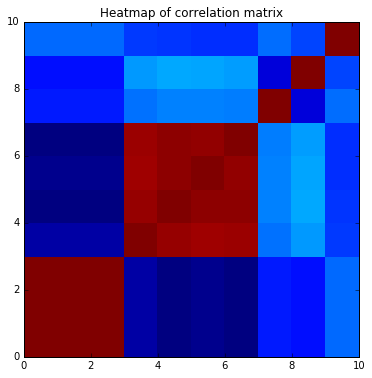

In [5]:
# Compute matrix of correlation coefficients
# each row of X needs to be a predictor so transpose X
corr_matrix = np.corrcoef(x.T)

# Display heat map 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.pcolor(corr_matrix)

ax.set_title('Heatmap of correlation matrix')

plt.show()

**By visually inspecting the data set, do find that some of the predictors are correlated amongst themselves?**
It is difficult to say from inspection of the data if the predictors are correlated but pairs of predictors can be compared - the values for predictors 0, 1 and 2 are very simiilar so it is likely that these predictors are correlated. Predictors 4, 5 and 6 also have similar values so may be correlated as well. 

**Do the predictors fall naturally into groups based on the correlation values?**
There are regions of red in the heat map which correspond to predictors which are correlated with each other. 0, 1 and 2 are strongly correlated, and 4, 5 and 6 are also correlated.  As the predictors within these groups are correlated amongst themselves, only one of them is necessary in the predictor selection. 

**If you were asked to select a minimal subset of predictors based on the correlation information in order to build a good regression model, how many predictors will you pick, and which ones will you choose?**
From the groups of correlated predictors, only one is necessary, so one predictor out of 0,1,2 and one predictor from the set 4,5,6. The remaining predictors 3,7,8,9 are not correlated so would all need to be included, resulting in a set of 6 predictors. 

### Part (b): Selecting minimal subset of predictors

- Apply the variable selection methods discussed in class to choose a minimal subset of predictors that yield high prediction accuracy:
    
    - Exhaustive search
    
    - Step-wise forward selection **or** Step-wise backward selection  

&emsp;&nbsp;&nbsp; In each method, use the Bayesian Information Criterion (BIC) to choose the subset size.

- Do the chosen subsets match the ones you picked using the correlation matrix you had visualized in Part (a)?

**Note**: You may use the `statsmodels`'s `OLS` module to fit a linear regression model and evaluate BIC. You may **not** use library functions that implement variable selection.

In [9]:
### Best Subset Selection
min_bic = 1e10 # set some initial large value for min BIC score
best_subset = [] # best subset of predictors

# Create all possible subsets of the set of 10 predictors
predictor_set = set(range(10)) # predictor set = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Repeat for every possible size of subset
for size_k in range(10): 
    # Create all possible subsets of size 'size', 
    # using the 'combination' function from the 'itertools' library
    subsets_of_size_k = it.combinations(predictor_set, size_k + 1) 
    
    max_r_squared = -1e10 # set some initial small value for max R^2 score
    best_k_subset = [] # best subset of predictors of size k
    
    # Iterate over all subsets of our predictor set
    for predictor_subset in subsets_of_size_k:    
        # Use only a subset of predictors in the training data
        x_subset = x[:, predictor_subset]

        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Update max R^2 and best predictor subset of size k
        # If current predictor subset has a higher R^2 score than that of the best subset 
        # we've found so far, remember the current predictor subset as the best!
        if(r_squared > max_r_squared): 
            max_r_squared = r_squared
            best_k_subset = predictor_subset[:]
                

    # Use only the best subset of size k for the predictors
    x_subset = x[:, best_k_subset]
        
    # Fit and evaluate BIC of the best subset of size k
    model = OLS(y, x_subset)
    results = model.fit()
    bic = results.bic
    
    # Update minimum BIC and best predictor subset
    # If current predictor has a lower BIC score than that of the best subset 
    # we've found so far, remember the current predictor as the best!
    if(bic < min_bic): 
        min_bic = bic
        best_subset = best_k_subset[:]
    
print('Best subset by exhaustive search:')
print sorted(best_subset)

Best subset by exhaustive search:
[0, 5, 7, 8, 9]


R2 depends monotonically with RSS, BIC depends monotonically with RSS within a subset.
Therefore the highest R2 and min BIC will result in the best predictor

In [12]:
### Step-wise Forward Selection
d = x.shape[1] # total no. of predictors

# Keep track of current set of chosen predictors, and the remaining set of predictors
current_predictors = [] 
remaining_predictors = range(d)

# Set some initial large value for min BIC score for all possible subsets
global_min_bic = 1e10 

# Keep track of the best subset of predictors
best_subset = [] 

# Iterate over all possible subset sizes, 0 predictors to d predictors
for size in range(d):    
    max_r_squared = -1e10 # set some initial small value for max R^2
    best_predictor = -1 # set some throwaway initial number for the best predictor to add
    bic_with_best_predictor = 1e10 # set some initial large value for BIC score   
        
    # Iterate over all remaining predictors to find best predictor to add
    for i in remaining_predictors:
        # Make copy of current set of predictors
        temp = current_predictors[:]
        # Add predictor 'i'
        temp.append(i)
                                    
        # Use only a subset of predictors in the training data
        x_subset = x[:, temp]
        
        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Check if we get a higher R^2 value than than current max R^2, if so, update
        if(r_squared > max_r_squared):
            max_r_squared = r_squared
            best_predictor = i
            bic_with_best_predictor = results.bic
    
    # Remove best predictor from remaining list, and add best predictor to current list
    remaining_predictors.remove(best_predictor)
    current_predictors.append(best_predictor)
    
    # Check if BIC for with the predictor we just added is lower than 
    # the global minimum across all subset of predictors
    if(bic_with_best_predictor < global_min_bic):
        best_subset = current_predictors[:]
        global_min_bic = bic_with_best_predictor
    
print 'Step-wise forward subset selection:'
print sorted(best_subset) # add 1 as indices start from 0

Step-wise forward subset selection:
[0, 5, 7, 8, 9]


In [13]:
##  Step-wise Backward Selection
d = x.shape[1] # total no. of predictors

# Keep track of current set of chosen predictors
current_predictors = range(d)

# First, fit and evaluate BIC using all 'd' number of predictors
model = OLS(y, x)
results = model.fit()
bic_all = results.bic

# Set the minimum BIC score, initially, to the BIC score using all 'd' predictors
global_min_bic = bic_all
# Keep track of the best subset of predictors
best_subset = [] 

# Iterate over all possible subset sizes, d predictors to 1 predictor
for size in range(d - 1, 1, -1): # stop before 0 to avoid choosing an empty set of predictors
    max_r_squared = -1e10 # set some initial small value for max R^2
    worst_predictor = -1 # set some throwaway initial number for the worst predictor to remove
    bic_without_worst_predictor = 1e10 # set some initial large value for min BIC score  
        
    # Iterate over current set of predictors (for potential elimination)
    for i in current_predictors:
        # Create copy of current predictors, and remove predictor 'i'
        temp = current_predictors[:]
        temp.remove(i)
                                    
        # Use only a subset of predictors in the training data
        x_subset = x[:, temp]
        
        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Check if we get a higher R^2 value than than current max R^2, if so, update
        if(r_squared > max_r_squared):
            max_r_squared = r_squared
            worst_predictor = i
            bic_without_worst_predictor = results.bic
          
    # Remove worst predictor from current set of predictors
    current_predictors.remove(worst_predictor)
    
    # Check if BIC for the predictor we just removed is lower than 
    # the global minimum across all subset of predictors
    if(bic_without_worst_predictor < global_min_bic):
        best_subset = current_predictors[:]
        global_min_bic = bic_without_worst_predictor
    
print 'Step-wise backward subset selection:'
print sorted(best_subset)

Step-wise backward subset selection:
[2, 5, 7, 8, 9]


**Do the chosen subsets match the ones you picked using the correlation matrix you had visualized in Part (a)?**

Some of the predictors match the ones chosen from Part (a). 
Exhaustive: [0, 5, 7, 8, 9]
Forward: [0, 5, 7, 8, 9] 
Backward: [2, 5, 7, 8, 9]

The three methods return similar results for the predictor subsets with exhaustive search and forward subset selection resulting in subsets with exactly the same predictors and backward selection differing in the choice of predictor 2 instead of 0. In each of the three methods, only one predictor has been chosen from each of the correlated predictor sets {0,1,2}, {4,5,6}. Out of the remaining four uncorrelated predictors {3,7,8,9}, three have been chosen. 


stepwise - only use the predictors selected from that subset for the remaining subsets
size 1  - choose x1
size 2 - only choose subsets which have subset 1
size 3 - only include subsets with best predictors from size 2

But this method is not optimal!!

Create two lists 
- current predictors and remaining predictors
- best predictors at each stage get added to the current list
- remaining predictors used to form the subsets with the current predictors

Cannot use R2 to decide between the best subset as the R2 increases with the number of predictors as the flexibility of the model increases. 
Have to use AIC/BIC as they have a term which penalises models with larger number of terms due to the log(k) temrs. 


### Part (c): Apply Lasso and Ridge regression

- Apply Lasso regression with regularization parameter $\lambda = 0.01$ and fit a regression model.

    - Identify the predictors that are assigned non-zero coefficients. Do these correspond to  the correlation matrix in Part (a)?


- Apply Ridge regression with regularization parameter $\lambda = 0.01$ and fit a regression model.

    - Is there a difference between the model parameters you obtain different and those obtained from Lasso regression? If so, explain why.

    - Identify the predictors that are assigned non-zero coefficients. Do these correspond to  the correlation matrix in Part (a)?


- Is there anything peculiar that you observe about the coefficients Ridge regression assigns to the first three predictors? Do you observe the same with Lasso regression? Give an explanation for your observation.

**Note**: You may use the `statsmodels` or `sklearn` to perform Lasso and Ridge regression.

In [14]:
# Lasso regression
reg = Lasso_Reg(alpha = 0.01)
reg.fit(x, y)
coefficients = reg.coef_

print 'Lasso:'
print 'Coefficients:', coefficients
print  'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0]

Lasso:
Coefficients: [ 0.02717417  0.          0.         -0.         -0.02532806 -0.         -0.
  0.04397321 -0.40612185 -0.22260474]
Predictors with non-zero coefficients: [0, 4, 7, 8, 9]


In [15]:
# Ridge regression: Fit and evaluate 
reg = Ridge_Reg(alpha = 0.01)
reg.fit(x, y)
coefficients = reg.coef_

print 'Ridge:'
print 'Coefficients:', coefficients
print 'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0]

Ridge:
Coefficients: [ 0.04353543  0.04353543  0.04353543  0.55217415 -0.19706852 -0.61421737
  0.30484213  0.18742866 -0.50083242 -0.35908145]
Predictors with non-zero coefficients: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Lasso Regression
- Some of the predictors with non zero coefficients match the predictors chosen from the correlation matrix - 0,7,8,9 are in accordance with the previous choice but the Lasso model also chooses predictor 4 which was not chosen previously. However similar to part (b), only one predictor has been chosen from each of the correlated predictor sets {0,1,2}, {4,5,6} and out of the remaining four uncorrelated predictors {7,8,9,10}, three have been chosen. 

Ridge Regression 
- All predictors have non zero coefficients as this method does not squash coefficient values to zero like Lasso regression
- The parameter values are very different to the values from Lasso regression 
- Three of the parameters have the same coefficient 0.0435

With Ridge Regression, the coefficients for predictors 0, 1 and 2 are all the same as the predictors are correlated. However for Lasso Regression, predictor 0 has a non-zero coefficient and predictors 1 and 2 have zero coefficient as they are not necessary for the model (as they are correlated with predictor 0). Similarly from the other subset of correlated predictors {4,5,6}, predictor 4 has a non-zero coefficient while predictors 5 and 6 have zero coefficient. 

## Problem 2: Cross-validation and Bootstrapping
In this problem, you will work with an expanded version of the automobile pricing data set you analyzed in Homework 3. The data set is contained ``dataset_2.txt``, with 26 attribues (i.e. predictors) for each automobile and corresponding prices. 

### Part(a): Encode categorical attributes and fill missing values
Identify the categorical attributes in the data. Replace their values with the one-hot binary encoding. You may do this using the `get_dummies()` function in `pandas`. If you do this task correctly, you should get a total of 69 predictors after the encoding.


In [287]:
data = pd.read_csv('./datasets/dataset_2.txt')
data.head(5)

,horsepower,highway-mpg,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,...,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,peak-rpm,city-mpg,price
0,95.0,24.0,0.0,120.232558,peugot,gas,std,four,wagon,rwd,...,l,four,120.0,mpfi,3.46,2.19,8.4,5000.0,19.0,16695.0
1,116.0,30.0,2.0,134.000000,toyota,gas,std,two,hardtop,rwd,...,ohc,four,146.0,mpfi,3.62,3.50,9.3,4800.0,24.0,11199.0
2,121.0,28.0,0.0,188.000000,bmw,gas,std,two,sedan,rwd,...,ohc,six,164.0,mpfi,3.31,3.19,9.0,4250.0,21.0,20970.0
3,184.0,16.0,0.0,120.232558,mercedes-benz,gas,std,four,sedan,rwd,...,ohcv,eight,308.0,mpfi,3.80,3.35,8.0,4500.0,14.0,40960.0
4,111.0,29.0,0.0,102.000000,subaru,gas,turbo,four,sedan,4wd,...,ohcf,four,108.0,mpfi,3.62,2.64,7.7,4800.0,24.0,11259.0


In [273]:
x_df = data.iloc[:, 0:-1]
y_df = data.iloc[:,-1]

num_predictors = np.shape(x_df)[1]
new_df = pd.DataFrame({})

for column in x_df.columns:
    # check for categorical variables: if number of unique items is less than 8 or data type is an object
    if (len(x_df[column].unique()) < 8 or (x_df[column].dtype == np.dtype('object'))):
        # apply one-hot encoding
        encoded_col = pd.get_dummies(x_df[column])
        new_df = pd.concat([new_df, encoded_col], axis=1) 
    else:
        new_df = pd.concat([new_df, x_df[column]], axis=1)      
new_df.head()

,horsepower,highway-mpg,-2.0,0.0,1.0,1.09604519774,2.0,3.0,normalized-losses,audi,...,1bbl,2bbl,idi,mpfi,spdi,bore,stroke,compression-ratio,peak-rpm,city-mpg
0,95.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,120.232558,0.0,...,0.0,0.0,0.0,1.0,0.0,3.46,2.19,8.4,5000.0,19.0
1,116.0,30.0,0.0,0.0,0.0,0.0,1.0,0.0,134.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,3.62,3.50,9.3,4800.0,24.0
2,121.0,28.0,0.0,1.0,0.0,0.0,0.0,0.0,188.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,3.31,3.19,9.0,4250.0,21.0
3,184.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0,120.232558,0.0,...,0.0,0.0,0.0,1.0,0.0,3.80,3.35,8.0,4500.0,14.0
4,111.0,29.0,0.0,1.0,0.0,0.0,0.0,0.0,102.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,3.62,2.64,7.7,4800.0,24.0


### Part (b): Apply regular linear regression
- Split the data set into train and test sets, with the first 25% of the data for training and the remaining for testing.  


- Use regular linear regression to fit a model to the training set and evaluate the R^2 score of the fitted model on both the training and test sets. What do you observe about these values?


- You had seen in class that the R^2 value of a least-squares fit to a data set would lie between 0 and 1. Is this true for the test R^2 values reported above? If not, give a reason for why this is the case.


- Is there a need for regularization while fitting a linear model to this data set?

**Note**: You may use the `statsmodels` or `sklearn` to fit a linear regression model and evaluate the fits.

In [326]:
# Convert data frame to array
x = new_df.values
y = y_df.values

n = np.shape(new_df)[0]
n_train = int(np.round(n*0.25))

# Take first 25% for training and the rest for testing
x_train = x[0:n_train, :]
x_test = x[n_train:, :]
y_train = y[0:n_train]
y_test = y[n_train:]


In [320]:
# Standardise the predictors

# needed to remove zero values from the standard deviations - some of the columns of x_train.std are
# zero as these columns correspond to categorical variables where the entries are all 0 as none of them are present

remove_zeros = lambda el: 1 if el[0] <0.000001 else el[0]
std_train = x_train.std(axis=0).reshape(69,1)
std_train_fixed = np.apply_along_axis(remove_zeros, 1, std_train)
std_test = x_test.std(axis=0).reshape(69,1)
std_test_fixed = np.apply_along_axis(remove_zeros, 1, std_test)

x_train = x_train/std_train_fixed
x_test = x_test/std_test_fixed

In [327]:
# OLS
reg = Lin_Reg()
reg.fit(x_train, y_train)

test_r_squared_plain = reg.score(x_test, y_test)
train_r_squared_plain = reg.score(x_train, y_train)

print 'R2 of linear fit on testing data: ', test_r_squared_plain
print 'R2 of linear fit on training data: ', train_r_squared_plain

R2 of linear fit on testing data:  -5.97542556701
R2 of linear fit on training data:  1.0


Both $R^2$ values for the test set is a large negative number and the $R^2$ for the training set is exactly 1. The R2 values do not lie between 0 and 1 as expected. 

WHY????

**Is there a need for regularization while fitting a linear model to this data set?**

This data set has 69 predictors, not all of which may influence the price and hence the predictions - therefore so regularisation can help with reducing the number of parameters in the linear model. 

### Part (c): Apply Ridge regression

- Apply Ridge regression on the training set for different values of the regularization parameter $\lambda$ in the range $\{10^{-7}, 10^{-6}, \ldots, 10^7\}$. Evaluate the R^2 score for the models you obtain on both the train and test sets. Plot both values as a function of $\lambda$. 


- Explain the relationship between the regularization parameter and the training and test R^2 scores.


- How does the best test R^2 value obtained using Ridge regression compare with that of plain linear regression? Explain.

**Note**: You may use the `statsmodels` or `sklearn` to fit a ridge regression model and evaluate the fits.

In [328]:
def RidgeReg(x_test, y_test, x_train, y_train, min_el, max_el):
    # create a vector of lambda exponents
    ells = np.linspace(min_el, max_el, 100)
    num_lambdas = len(ells)
    num_predictors = np.shape(x_train)[1]
    
    # empty arrays to store r2 values and coefficients
    train_r_squared = np.zeros(num_lambdas)
    test_r_squared = np.zeros(num_lambdas)
    coeff_a =np.zeros((num_lambdas, num_predictors))
    
    for i, ell in enumerate(ells):
        # fit ridge regression model
        reg = Ridge_Reg(alpha=10**ell)
        reg.fit(x_train, y_train)
        # calculate r2 for testing and training sets
        r2_test = reg.score(x_test, y_test)
        r2_train = reg.score(x_train, y_train)
        test_r_squared[i] = r2_test
        train_r_squared[i] = r2_train
        coeff_a[i,:] = reg.coef_
        
    return train_r_squared, test_r_squared, coeff_a, ells
        
def PlotR2(lambdas, test_r_squared_plain, train_r_squared, test_r_squared):
    # Plot train and test R-squared as a function parameter value
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    ax.axhline(y = test_r_squared_plain, c='g', label = 'Plain Regression')
    ax.semilogx(10.0**lambdas, (train_r_squared), c='b', label='Ridge: Train')
    ax.semilogx(10.0**lambdas, (test_r_squared), c='r', label='Ridge: Test')

    ax.set_xlabel('Regularization parameter $\lambda$')
    ax.set_ylabel(r'$R^2$ score')
    #ax.set_ylim((test_r_squared_plain-0.2, 1.2))
    ax.legend(loc = 'best')
    return ax
    print 'Regression: max R^2 score on training set', max(train_r_squared)
    print 'Regression: max R^2 score on test set', max(test_r_squared)
    plt.show()

def PlotCoeff(lambdas, coeff_a):
    plt.figure(figsize=(12,12))
    h=plt.semilogx(10**lambdas, coeff_a);
    plt.ylabel("Standarized Coefficients")
    plt.xlabel(r'Regularization parameter $\lambda$')
    print (len(new_df.columns.values))
    plt.legend(h, new_df.columns.values, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    

69


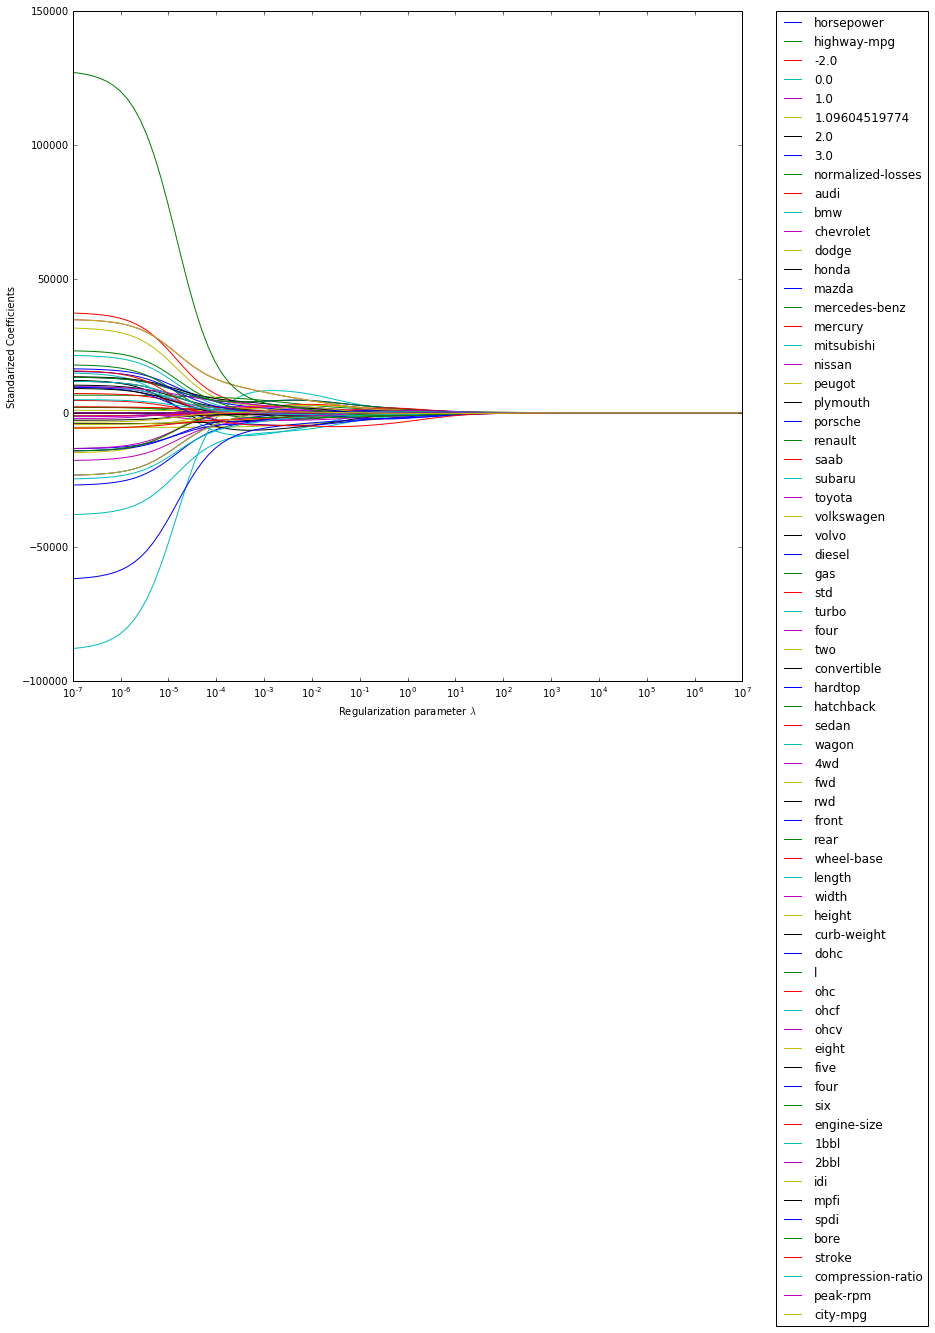

In [329]:
train_r_squared, test_r_squared, coeff_a, lambdas = RidgeReg(x_test, y_test, x_train, y_train, -7,7) 
PlotCoeff(lambdas, coeff_a)

(0, 1)

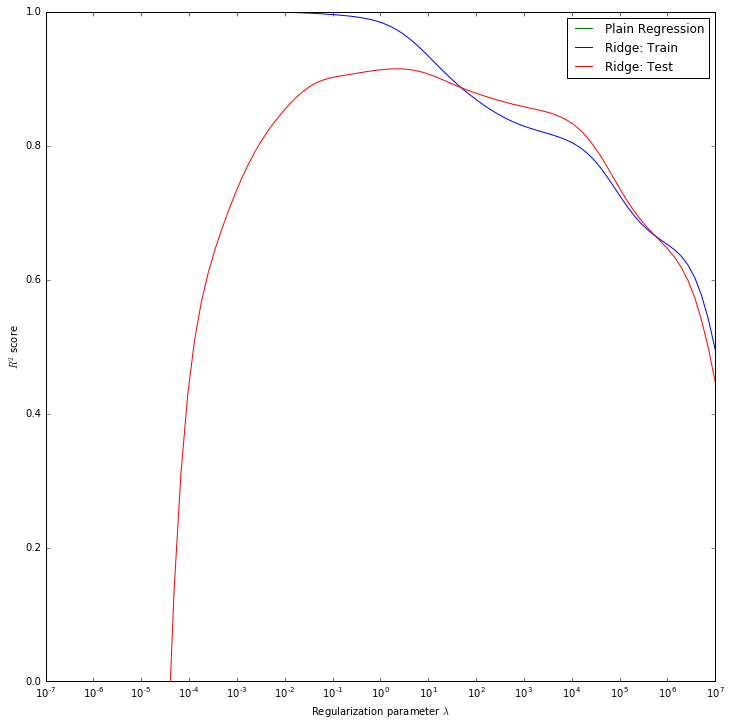

In [330]:
ax = PlotR2(lambdas, test_r_squared_plain, train_r_squared, test_r_squared)
ax.set_ylim(0,1)

**Explain the relationship between the regularization parameter and the training and test R^2 scores.**

For very small values of $\lambda$ the $R^2$ for the test set is highly negative. The $R^2$ value increases sharply from lambda of $10^-4$, reaching a peak of 0.91. For subsequent values of lambda, the $R^2$ of the testing and training set match closely and both decrease to 0 for $\lambda$  values greater than $10^3$. 

**How does the best test R^2 value obtained using Ridge regression compare with that of plain linear regression? Explain.**

Best $R^2$ from ridge regression is much higher than best $R^2$ from linear regression. Ridge regression reduced the coefficients of some predictors so they are dampened in the model. 

### Part (d): Tune regularization parameter using cross-validation and bootstrapping
-  Evaluate the performance of the Ridge regression for different regularization parameters $\lambda$ using 5-fold cross validation **or** bootstrapping on the training set. 

    - Plot the cross-validation (CV) or bootstrapping R^2 score as a function of $\lambda$. 
    
    - How closely does the CV score or bootstrapping score match the R^2 score on the test set? Does the model with lowest CV score or bootstrapping score correspond to the one with maximum R^2 on the test set?
    
    - Does the model chosen by CV or bootstrapping perform better than plain linear regression?

**Note**: You may use the `statsmodels` or `sklearn` to fit a linear regression model and evaluate the fits. You may also use `kFold` from `sklearn.cross_validation`. 

(0, 1)

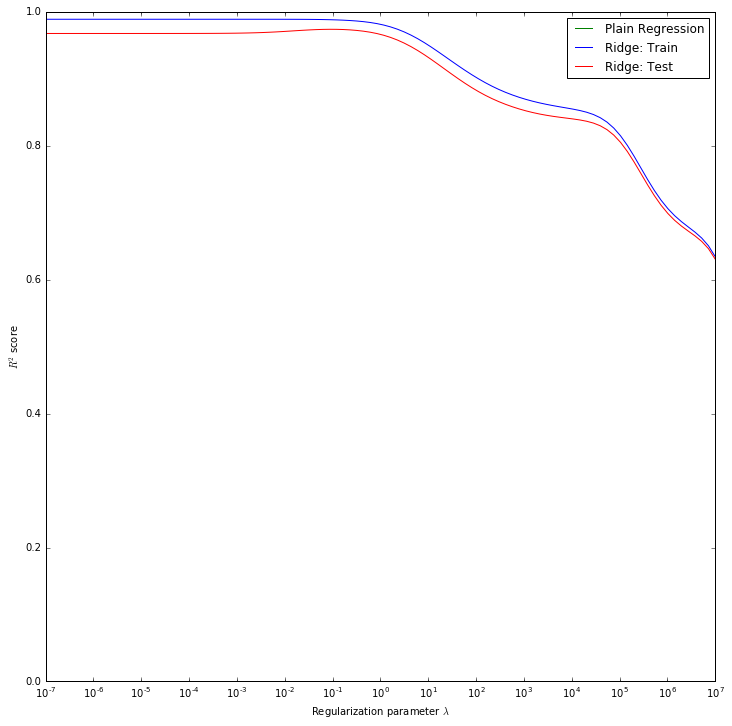

In [325]:
x = new_df.values
y = y_df.values

num_points = np.shape(x)[0]
train_k_r_squared = np.zeros((100, 5))
test_k_r_squared = np.zeros((100, 5))

i =0
for train_index, test_index in KFold(n, n_folds=5):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_r_squared, test_r_squared, coeff_a, lambdas = RidgeReg(X_test, y_test, X_train, y_train, -7,7) 
    train_k_r_squared[:,i] = train_r_squared
    test_k_r_squared[:,i] = test_r_squared
    i+=1

test_k_mean_r_squared = np.mean(test_k_r_squared, axis=1) # average of 5 folds for each value of lambda
train_k_mean_r_squared = np.mean(train_k_r_squared, axis=1)
ax = PlotR2(lambdas, test_r_squared_plain, train_k_mean_r_squared, test_k_mean_r_squared)
ax.set_ylim(0,1)

**How closely does the CV score or bootstrapping score match the R^2 score on the test set?**

The test set CV score matches the R2 score on the test set for lambdas greater than 10-1. The R2 score on the test set for lambdas less that 10-1 are highly negative whereas the CV score is close to 1

**Does the model with lowest CV score or bootstrapping score correspond to the one with maximum R^2 on the test set?**

?????

**Does the model chosen by CV or bootstrapping perform better than plain linear regression?**

With plain linear regression, the R2 score for the test set was highly negative. With CV and a lambda of 10-1, the R2 score is close to 1 so performs significantly better. 

## Problem 3: Ridge regression *via* ordinary least-squares regression

We present an approach to implement Ridge regression using oridinary least-squares regression. Given a matrix of responses $\mathbf{X} \in \mathbb{R}^{n\times p}$ and response vector $\mathbf{y} \in \mathbb{R}^{n}$, one can implement Ridge regression with regularization parameter $\lambda$ as follows:

- Augment the matrix of predictors $\mathbf{X}$ with $p$ new rows containing the scaled identity matrix $\sqrt{\lambda}\mathbf{I} \in \mathbb{R}^{p \times p}$, i.e.
$$\overline{\mathbf{X}} \,=\, 
\begin{bmatrix}
X_{11} & \ldots & X_{1p}\\
\vdots & \ddots & \vdots\\
X_{n1} & \ldots & X_{np}\\
\sqrt{\lambda} & \ldots & 0\\
\vdots & \ddots & \vdots\\
0 & \ldots & \sqrt{\lambda}
\end{bmatrix}
\,\in\,
\mathbb{R}^{(n+p)\times p}
.
$$


- Augment the response vector $\mathbf{y}$ with a column of $p$ zeros, i.e.
$$
\overline{\mathbf{y}} \,=\, 
\begin{bmatrix}
y_{1}\\
\vdots\\
y_{n}\\
0\\
\vdots\\
0
\end{bmatrix}
\,\in\,
\mathbb{R}^{n+p}.
$$


- Apply ordinary least-squares regression on the augmented data set $(\overline{\mathbf{X}}, \overline{\mathbf{y}})$.

### Part (a): Show the proposed approach implements Ridge regression
Show that the approach proposed above implements Ridge regression with parameter $\lambda$.

The objective function for ridge regression is of the form:

$$f(\beta) = (Y-X\beta)^T(Y-X\beta) + \lambda\beta^2 $$

The normal equations for ridge regression take the form:
$$(X^T\,X + \lambda I)\beta =  X^T Y $$

so $\beta$ could be solved using the following matrix inverse:

$$\beta = (X^T\,X + \lambda I)^{-1} X^T Y $$

Alternatively, X and Y can be augmented so the normal equation has the same form as for ordinary least sqaures. This requires incorporating the $\lambda\beta^2$ into an augmented $\overline{\mathbf{X}}$ matrix and $\overline{\mathbf{y}}$ vector.  As $\lambda >0$ the square root $\sqrt{\lambda}$ will be positive so the matrix X (an n×p matrix) can be augemented by appending the p x p matrix  $\sqrt{\lambda}I$, and the vector Y can be extended by appending a column of p zeros. The product $(\overline{\mathbf{y}}-\overline{\mathbf{X}}\beta)^T(\overline{\mathbf{y}}-\overline{\mathbf{X}}\beta)$ adds an additional p terms to the objective function of ordinary least squares of the form: 

$$(0 - \sqrt{\lambda}\beta_i)^2 = \lambda \beta_i^2$$

which corresponds to the additional term in the ridge regression objective function.

Therefore the normal equation for $\beta$ using ridge regression can be rewritten as
$$(Y-X\beta)^T(Y-X\beta) + \lambda\beta^2  = (\overline{\mathbf{y}}-\overline{\mathbf{X}}\beta)^T(\overline{\mathbf{y}}-\overline{\mathbf{X}}\beta)$$

From the right hand side the normal equation can be written as:
$${\overline{\mathbf{X}}}^T\,\overline{\mathbf{X}}\beta =  {\overline{\mathbf{X}}}^T \overline{\mathbf{y}} $$

which can be solved using ordinary least squares. 


### Part (b): Debug our implementation of ridge regression
You're a grader for CS109A, the following is an implemention of Ridge regression (via the above approach) submitted by a student. The dataset is ``dataset_3.txt``. The regression model is fitted to a training set, and the R^2 scores of the fitted model on the training and test sets are plotted as a function of the regularization parameter. Grade this solution according to the following rubric (each category is equally weighted): 

- correctness

- interpretation (if applicable)

- code/algorithm design

- presentation

In addition to providing an holistic grade (between 0 to 5), provide a corrected version of this code that is submission quality.

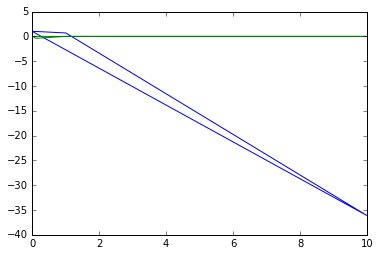

In [122]:
# Fit
def ridge(x_train, y_train, reg_param):
    n=np.shape(x_train)[0] # x is an n x p matrix so should be taking the element 1 of the shape
    x_train=np.concatenate((x_train,reg_param*np.identity(n)),axis=1) 
    # need to take the square root of the reg_param and also concatenate along axis 0 not axis 1
    y_train_=np.zeros((n+np.shape(x_train)[1],1)) # wrong dimension of x used 
    for c in range(n):
        y_train_[c]= y_train[c]
    import sklearn # group all import statements at the top of the code block
    model = sklearn.linear_model.LinearRegression()
    model.fit(x_train,y_train.reshape(-1,1)) # don't reshape inline and also dimensions of x and y don't match
    return model

# Score
def score(m,x_test,y_test, reg_param):
    # same errors as above
    n=np.shape(x_train)[0]
    x_test=np.concatenate((x_test,reg_param*np.identity(n)),axis=1)
    y_test_=np.zeros((n+np.shape(x_test)[1],1))
    for c in range(n):
        y_test_[c]= y_test[c]
    return m.score(x_test,y_test.reshape(-1,1))

# Load
data = np.loadtxt('datasets/dataset_3.txt', delimiter=',')
n = data.shape[0]
n = int(np.round(n*0.5))
x_train = data[0:n,0:100] # also adding the 100th column?
y_train = data[0:n,100] 
x_test = data[n:2*n,0:100] 
y_test = data[n:2*n,100]

# Params
a=np.zeros(5)
for i in range(-2,2):
    a[i+2]=10**i

# Iterate
rstr =np.zeros(5)
rsts =np.zeros(5)
for j in range(0,5):    
    m =ridge(x_train,y_train,a[i])
    rstr[j]=score(m,x_train,y_train,a[j])
    rsts[i]=score(m,x_test,y_test,a[i])

# Plot
plt.plot(a,rstr)
plt.plot(a,rsts)

Grading:
- correctness
    - several careless errors in the implementation 
- interpretation (if applicable)
    - no interpretation of the code
- code/algorithm design
    - poor labelling of variables 
    - no commenting of code
- presentation
    - no legend or axes labels
    - no 

Grade 2/5

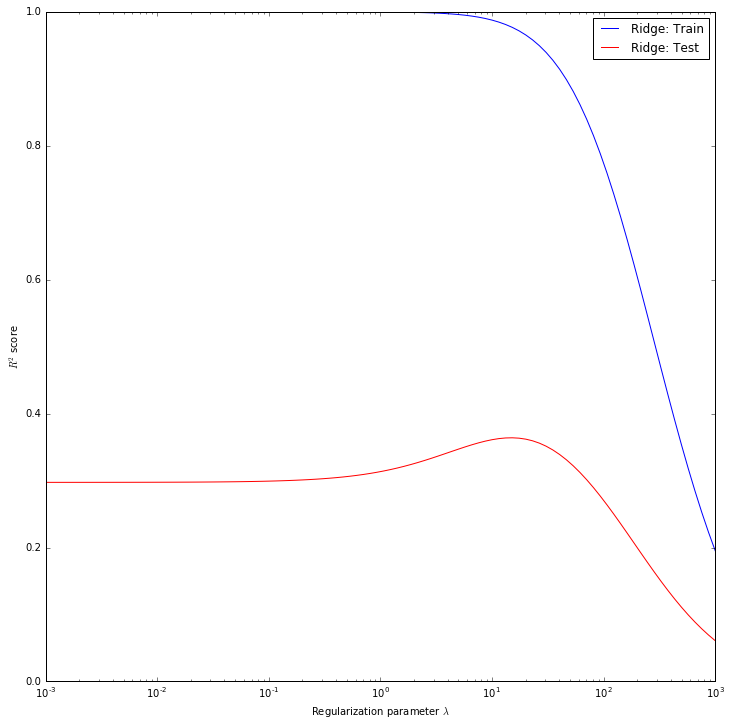

In [335]:
from sklearn.linear_model import LinearRegression as Lin_Reg

def ridge(x_train, y_train, reg_param):
    n,p =np.shape(x_train) # x is an n x p matrix
    # append a pxp matrix lambda*I to the X matrix
    x_train=np.concatenate((x_train,np.sqrt(10.0**reg_param)*np.identity(p)),axis=0)
    # append a column vector of length p to the y vector
    y_train=np.concatenate((y_train,np.zeros(p)),axis=0)
    model = Lin_Reg()
    model.fit(x_train,y_train)
    return model

# Load the data
data = np.loadtxt('datasets/dataset_3.txt', delimiter=',')

# Split into test and train sets, taking the first 25% for training
n = data.shape[0]
n_train = int(np.round(n*0.25))

x_train = data[0:n_train,0:-1]
y_train = data[0:n_train,-1]
x_test = data[n_train:,0:-1]
y_test = data[n_train:,-1]

# Standardise data
x_train = x_train / x_train.std(axis=0)
x_test = x_test / x_test.std(axis=0)

# Params
lambdas=np.linspace(-3,3, 100)
num_lambdas = len(lambdas)

# Initialise empty arrays for storing r2 values
r2_train =np.zeros(num_lambdas)
r2_test =np.zeros(num_lambdas)

# Iterate over the values of lambda
for i in range(num_lambdas):    
    model = ridge(x_train,y_train,lambdas[i])
    r2_train[i]=model.score(x_train,y_train)
    r2_test[i]=model.score(x_test,y_test)

# Plot the rsquared values as a function of lambda
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.semilogx(10.0**lambdas, (r2_train), c='b', label='Ridge: Train')
ax.semilogx(10.0**lambdas, (r2_test), c='r', label='Ridge: Test')

ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$R^2$ score')
ax.legend(loc = 'best')

## Challenge Problem: Predicting Outcome of a Fund-raising Campaign
You are provided a data set containing details of mail sent to 95,412 potential donors for a fund-raising campaign of a not-for-profit organization. This data set also contains the amount donated by each donor. The task is to build a model that can estimate the amount that a donor would donate using his/her attributes. The data is contained in the file `dataset_4.txt`. Each row contains 376 attributes for a donor, followed by the donation amount.

**Note**: For additional information about the attributes used, please look up the file `dataset_4_description.txt`. This files also contains details of attributes that have been omitted from the data set.

### Part (a): Fit regression model
Build a suitable model to predict the donation amount. How good is your model? 


### Part (b): Evaluate the total profit of the fitted model
Suppose you are told that the cost of mailing the donor is \$7. Use your model to maximize profit. Implement, explain and rigorously justify your strategy. How does your strategry compare with blanket mailing everyone.

### Part (c): Further Discussion
In hindsight, thoroughly discuss the appropriatenes of using a regression model for this dataset (you must at least address the suitability with respect to profit maximization and model assumptions). Rigorously justify your reasoning. 

Fitting a Regression Model to the dataset. 

Methodology:

1. Extract out the numerical predictors
2. Try OLS - split into training and testing sets and look at R2 score on test and training set
3. Try Ridge Regression - look at R2 on test and training set
4. Try Lasso Regression - look at R2
5. Use forward and backward selection to reduce predictor set
6. Model Assesment using cross validation

In [243]:
data_q4 = pd.read_csv('datasets/dataset_4.txt', sep=',')


In [247]:
# extract the predictors and the response 

x_df_q4 = data_q4.iloc[:, 0:-1]
y_df_q4 = data_q4.iloc[:,-1]

num_predictors_q4 = np.shape(x_df_q4)[1]
data_q4_numerical = pd.DataFrame({})

# only extract the numerical predictors and remove the categorical variables 
for column in x_df_q4.columns:
    if ((x_df_q4[column].dtype != np.dtype('object'))):
        data_q4_numerical = pd.concat([data_q4_numerical, x_df_q4[column]], axis=1)      
data_q4_numerical.head()

,TCODE,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,POP901,...,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,AVGGIFT,HPHONE_D,RFA_2F,CLUSTER2
0,2.0,10.0,2.0,25.0,40.0,27.0,11.0,4.0,1.0,2707.0,...,61.0,15.0,10.0,2.0,7.0,5.0,4.066667,1.0,3.0,3.0
1,0.0,0.0,1.0,37.0,58.0,16.0,8.0,1.0,5.0,2147.0,...,68.0,11.0,6.0,2.0,10.0,7.0,6.181818,1.0,3.0,14.0
2,0.0,5.0,0.0,33.0,24.0,39.0,6.0,5.0,1.0,2160.0,...,102.0,21.0,14.0,3.0,6.0,5.0,4.857143,1.0,3.0,11.0
3,0.0,0.0,0.0,34.0,20.0,54.0,2.0,3.0,1.0,13801.0,...,132.0,12.0,5.0,5.0,17.0,10.0,11.000000,0.0,2.0,2.0
4,1.0,10.0,0.0,21.0,53.0,8.0,5.0,4.0,11.0,1673.0,...,94.0,10.0,8.0,5.0,12.0,12.0,9.400000,1.0,3.0,22.0


In [267]:
x_q4 = data_q4_numerical.iloc[:, 0:-1].values
y_q4 = y_df_q4.values.reshape(len(y_df_q4.values), 1)

# ii. SPLIT TRAIN AND TEST SETS
# No. of training points
n = x_q4.shape[0]
n_train = int(np.round(n*0.25))

# First 25% train, remaining test 
# assume data has been randomly shuffled
x_q4_train = x_q4[:n_train,:]
y_q4_train = y_q4[:n_train]
x_q4_test = x_q4[n_train:,:]
y_q4_test = y_q4[n_train:]

# Scale the data 
x_q4_train = x_q4_train / x_q4_train.std(axis=0)
x_q4_test = x_q4_test / x_q4_test.std(axis=0)


In [268]:
# plain OLS
reg_q4 = Lin_Reg()
reg_q4.fit(x_q4_train, y_q4_train)

train_rsquared_q4 = reg_q4.score(x_q4_train, y_q4_train)
test_rsquared_q4 = reg_q4.score(x_q4_test, y_q4_test)

print 'Plain Regression: R^2 score on training set', train_rsquared_q4
print 'Plain Regression: R^2 score on test set', test_rsquared_q4

Plain Regression: R^2 score on training set 0.637205062491
Plain Regression: R^2 score on test set -2.23374021889


In [269]:
ridge_reg_q4 = Ridge_Reg(alpha=1.0)
ridge_reg_q4.fit(x_q4_train, y_q4_train)
train_rsquared_q4 = ridge_reg_q4.score(x_q4_train, y_q4_train)
test_rsquared_q4 = ridge_reg_q4.score(x_q4_test, y_q4_test)

print 'Plain Regression: R^2 score on training set', train_rsquared_q4
print 'Plain Regression: R^2 score on test set', test_rsquared_q4

Plain Regression: R^2 score on training set 0.635576016855
Plain Regression: R^2 score on test set -1.57432874055


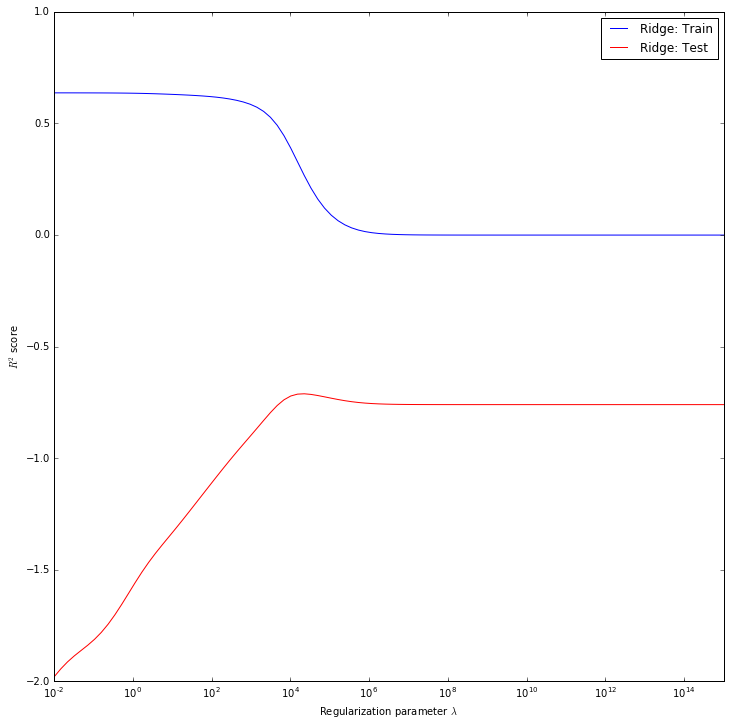

In [286]:
# try ridge regression with different values of lambda
train_r_squared, test_r_squared, coeff_a, lambdas = RidgeReg(x_q4_test, y_q4_test, x_q4_train, y_q4_train, -2,15) 
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.semilogx(10.0**lambdas, (train_r_squared), c='b', label='Ridge: Train')
ax.semilogx(10.0**lambdas, (test_r_squared), c='r', label='Ridge: Test')

ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$R^2$ score')
ax.legend(loc = 'best')

In [336]:
ridge_reg_q4 = Lasso_Reg(alpha=1.0)
ridge_reg_q4.fit(x_q4_train, y_q4_train)
train_rsquared_q4 = ridge_reg_q4.score(x_q4_train, y_q4_train)
test_rsquared_q4 = ridge_reg_q4.score(x_q4_test, y_q4_test)

print 'Plain Regression: R^2 score on training set', train_rsquared_q4
print 'Plain Regression: R^2 score on test set', test_rsquared_q4

Plain Regression: R^2 score on training set 0.553734721456
Plain Regression: R^2 score on test set -0.892929729247


In [338]:
def LassoReg(x_test, y_test, x_train, y_train, min_el, max_el):
    # create a vector of lambda exponents
    ells = np.linspace(min_el, max_el, 100)
    num_lambdas = len(ells)
    num_predictors = np.shape(x_train)[1]
    
    # empty arrays to store r2 values and coefficients
    train_r_squared = np.zeros(num_lambdas)
    test_r_squared = np.zeros(num_lambdas)
    coeff_a =np.zeros((num_lambdas, num_predictors))
    
    for i, ell in enumerate(ells):
        # fit ridge regression model
        reg = Lasso_Reg(alpha=10**ell)
        reg.fit(x_train, y_train)
        # calculate r2 for testing and training sets
        r2_test = reg.score(x_test, y_test)
        r2_train = reg.score(x_train, y_train)
        test_r_squared[i] = r2_test
        train_r_squared[i] = r2_train
        coeff_a[i,:] = reg.coef_
        
    return train_r_squared, test_r_squared, coeff_a, ells
        

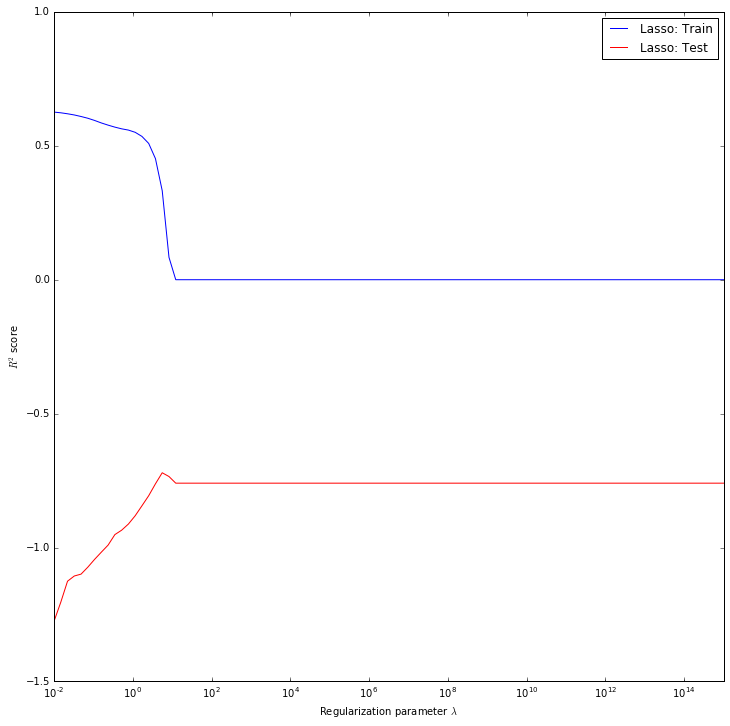

In [339]:
# try ridge regression with different values of lambda
train_r_squared, test_r_squared, coeff_a, lambdas = LassoReg(x_q4_test, y_q4_test, x_q4_train, y_q4_train, -2,15) 
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.semilogx(10.0**lambdas, (train_r_squared), c='b', label='Lasso: Train')
ax.semilogx(10.0**lambdas, (test_r_squared), c='r', label='Lasso: Test')

ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$R^2$ score')
ax.legend(loc = 'best')

#Predictor subset selection.

### Turn a categorical variable into a numerical variable and see if the prediction improves. 

In [ ]:
#Choose a categorical variable 